In [64]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Importando as bases de dados

Para isso, vou criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

Para cada arquivo da base de dados, vou importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [65]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')
base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    
    base_airbnb = pd.concat([base_airbnb, df], ignore_index=True)

display(base_airbnb)

id                            listing_url       scrape_id  \
0          14063     https://www.airbnb.com/rooms/14063  20180414160018   
1          17878     https://www.airbnb.com/rooms/17878  20180414160018   
2          24480     https://www.airbnb.com/rooms/24480  20180414160018   
3          25026     https://www.airbnb.com/rooms/25026  20180414160018   
4          31560     https://www.airbnb.com/rooms/31560  20180414160018   
...          ...                                    ...             ...   
902205  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
902206  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
902207  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
902208  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
902209  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

       last_scraped                                          name  \
0        2018-04-14                          Living in a Postcard   
1        2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2        2018-04-14              Nice and cozy near Ipanema Beach   
3        2018-04-14     Beautiful Modern Decorated Studio in Copa   
4        2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...             ...                                           ...   
902205   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
902206   2019-09-24                      Alugo para o Rock in Rio   
902207   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
902208   2019-09-24                     Cobertura Cinematografica   
902209   2019-09-24     Quarto em cobertura em frente à praia III   

                                                  summary  \
0       Besides the most iconic's view, our apartment ...   
1       Please note that special rates apply for New Y...   
2       My studio is located in the best  of Ipanema. ...   
3       Our apartment is a little gem, everyone loves ...   
4       This nice and clean 1 bedroom apartment is loc...   
...                                                   ...   
902205  Em estilo contemporâneo, o Transamerica Prime ...   
902206  Confortável apartamento, 2 quartos , sendo 1 s...   
902207  Apartamento quarto e sala COMPLETO para curtas...   
902208                               Cobertura alto nivel   
902209  Quarto em cobertura quadriplex com vista lindí...   

                                                    space  \
0                                                     NaN   
1       - large balcony which looks out on pedestrian ...   
2       The studio is located at Vinicius de Moraes St...   
3       This newly renovated studio (last renovations ...   
4       This nice and clean 1 bedroom apartment is loc...   
...                                                   ...   
902205                                                NaN   
902206  O apartamento estará com mobília completa disp...   
902207  Espaço ideal para até 5 pessoas. Cama de casal...   
902208                                                NaN   
902209                                                NaN   

                                              description experiences_offered  \
0       Besides the most iconic's view, our apartment ...                none   
1       Please note that special rates apply for New Y...                none   
2       My studio is located in the best  of Ipanema. ...                none   
3       Our apartment is a little gem, everyone loves ...                none   
4       This nice and clean 1 bedroom apartment is loc...                none   
...                                                   ...                 ...   
902205  Em estilo contemporâneo, o Transamerica Prime ...                none   
902206  Confortável apartamento, 2 quartos , sendo 1 s...                none   
902207  Apartamento quarto e sala COMPLETO para curtas...                none   
902208  

### Agora vou começar os tratamentos

- Como tenho muitas colunas, o modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o modelo de previsão, por isso, vou excluir algumas colunas da nossa base
- Tipos de colunas que vou excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês)
    3. Colunas preenchidas com texto livre -> Não rodarei nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais

In [66]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, teremos as seguintes colunas:


In [67]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


host_response_time host_response_rate host_is_superhost  \
0                      NaN                NaN                 f   
1           within an hour               100%                 t   
2           within an hour               100%                 f   
3           within an hour               100%                 f   
4           within an hour               100%                 t   
...                    ...                ...               ...   
902205      within an hour                93%                 f   
902206                 NaN                NaN                 f   
902207  within a few hours                74%                 f   
902208                 NaN                NaN                 f   
902209  a few days or more                38%                 f   

        host_listings_count   latitude  longitude property_type  \
0                       1.0 -22.946854 -43.182737     Apartment   
1                       2.0 -22.965919 -43.178962   Condominium   
2                       1.0 -22.985698 -43.201935     Apartment   
3                       3.0 -22.977117 -43.190454     Apartment   
4                       1.0 -22.983024 -43.214270     Apartment   
...                     ...        ...        ...           ...   
902205                  0.0 -23.003180 -43.342840     Apartment   
902206                  0.0 -22.966640 -43.393450     Apartment   
902207                 32.0 -22.962080 -43.175520     Apartment   
902208                  0.0 -23.003400 -43.341820     Apartment   
902209                  5.0 -23.010560 -43.363350     Apartment   

              room_type  accommodates  bathrooms  ...  \
0       Entire home/apt             4        1.0  ...   
1       Entire home/apt             5        1.0  ...   
2       Entire home/apt             2        1.0  ...   
3       Entire home/apt             3        1.0  ...   
4       Entire home/apt             3        1.0  ...   
...                 ...           ...        ...  ...   
902205  Entire home/apt             4        1.0  ...   
902206  Entire home/apt             4        2.0  ...   
902207  Entire home/apt             5        1.0  ...   
902208  Entire home/apt             4        1.0  ...   
902209     Private room             2        0.0  ...   

        review_scores_cleanliness  review_scores_checkin  \
0                             9.0                    9.0   
1                             9.0                   10.0   
2                            10.0                   10.0   
3                            10.0                   10.0   
4                            10.0                   10.0   
...                           ...                    ...   
902205                        NaN                    NaN   
902206                        NaN                    NaN   
902207                        NaN                    NaN   
902208                        NaN                    NaN   
902209                        NaN                    NaN   

       review_scores_communication review_scores_location review_scores_value  \
0                              9.0                    9.0                 9.0   
1                             10.0                    9.0                 9.0   
2                             10.0                   10.0                 9.0   
3                             10.0                   10.0                 9.0   
4                             10.0                   10.0                 9.0   
...                            ...                    ...                 ...   
902205                         NaN                    NaN                 NaN   
902206                         NaN                    NaN                 NaN   
902207                         NaN                    NaN                 NaN   
902208                         NaN                    NaN                 NaN   
902209                         NaN                    NaN                 NaN   

       instant_book

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como tenho muitos dados (mais de 900.000 linhas) vou excluir as linhas que contém dados NaN

In [68]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


- Agora vou excluir as linhas vazias

In [69]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

- Vou fazer isso porque as vezes o Python está lendo como texto alguma coluna que deveria ser um número, então é necessário corrigir

In [70]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) tenho que mudar o tipo de variável da coluna.

In [71]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vou basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manterei todas as features que temos.
    2. Excluir outliers (usarei como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que tenho fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vou começar pelas colunas de preço (resultado final que quero) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vou analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vou avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: Não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

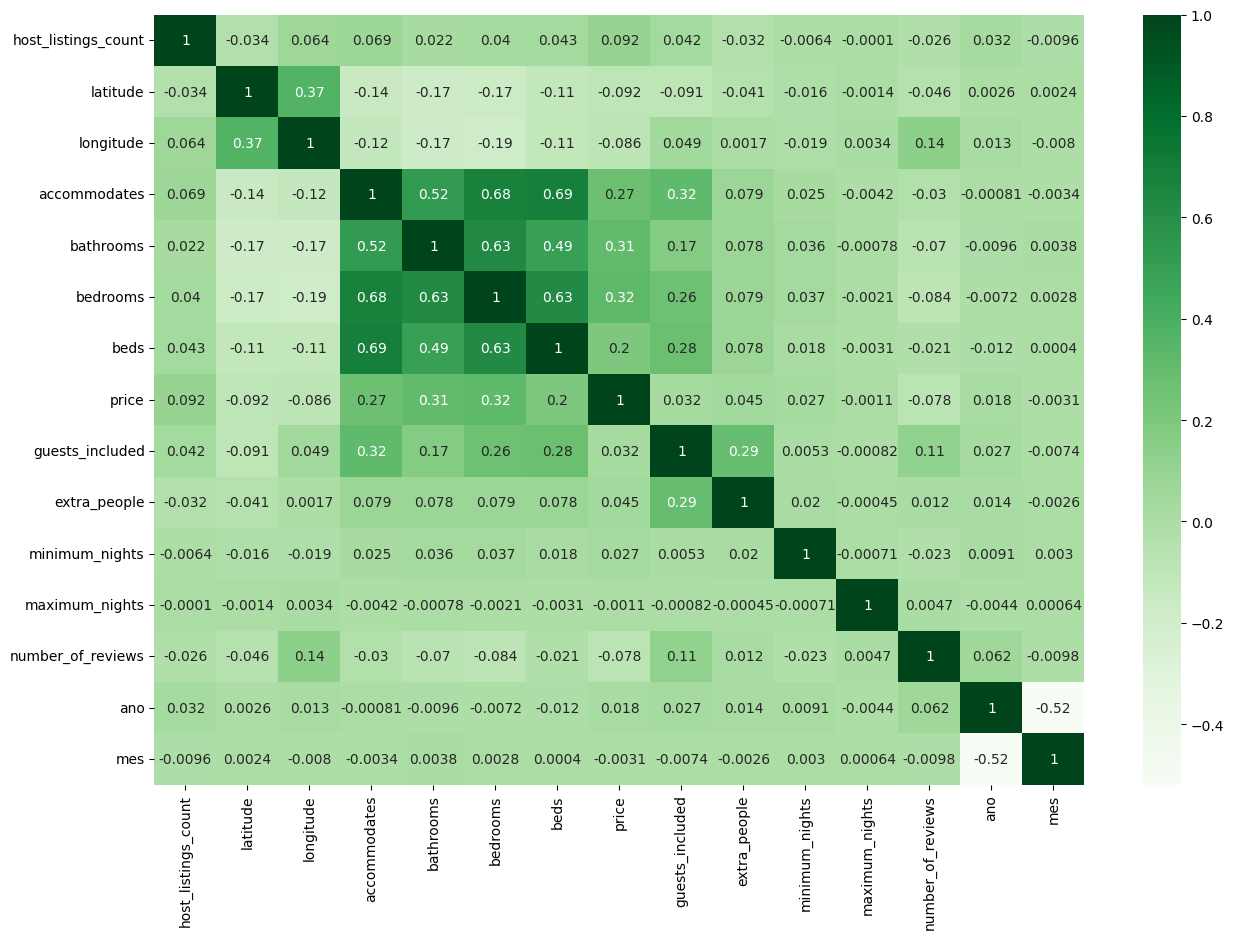

In [72]:
# Seleciona apenas as colunas numéricas
numerical_data = base_airbnb.select_dtypes(include='number')

# Cria o heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_data.corr(), annot=True, cmap='Greens')
plt.show()

### Definição de Funções para Análise de Outliers

Vou definir algumas funções para ajudar na análise de outliers das colunas

In [73]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [74]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price

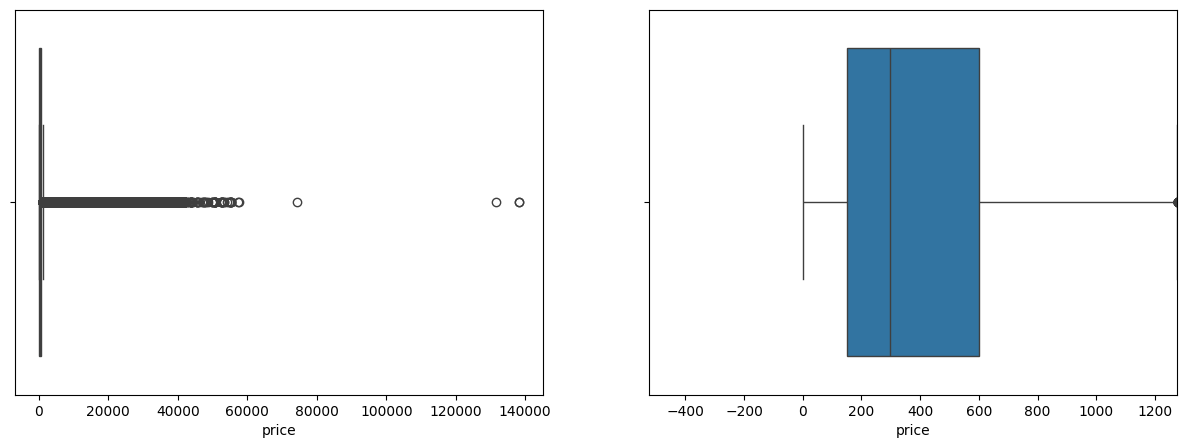

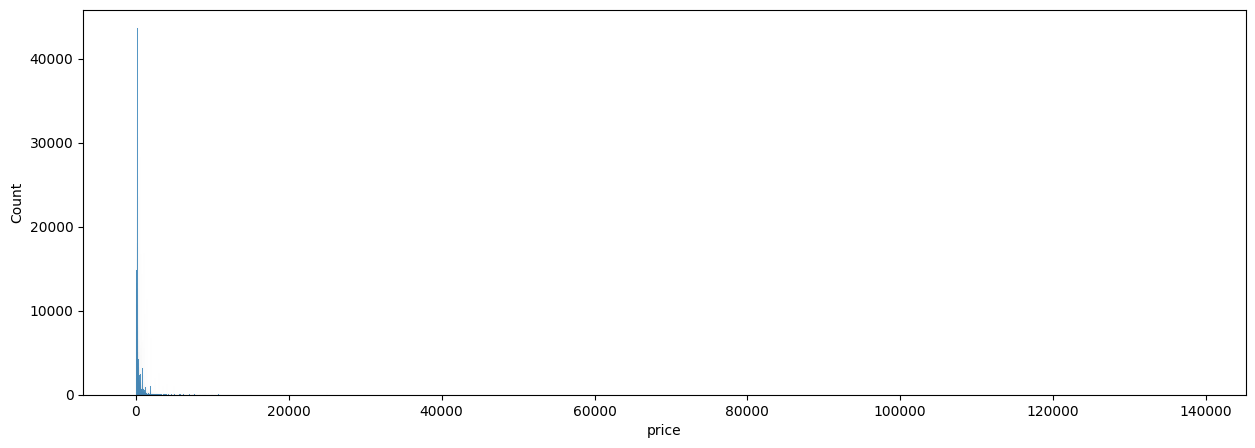

In [75]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estou construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o meu objetivo principal. Por isso, posso excluir esses outliers.

In [76]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


(810427, 23)


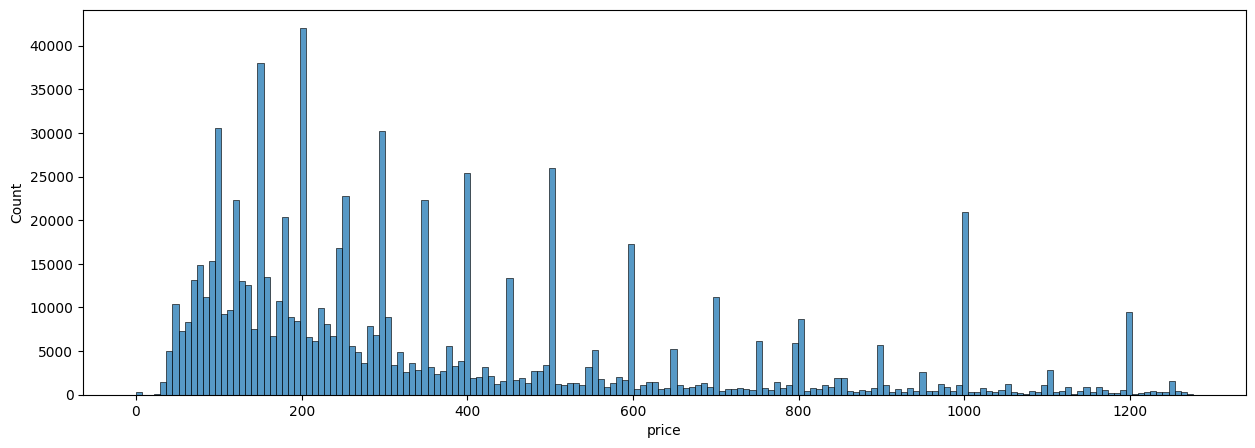

In [77]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra_people

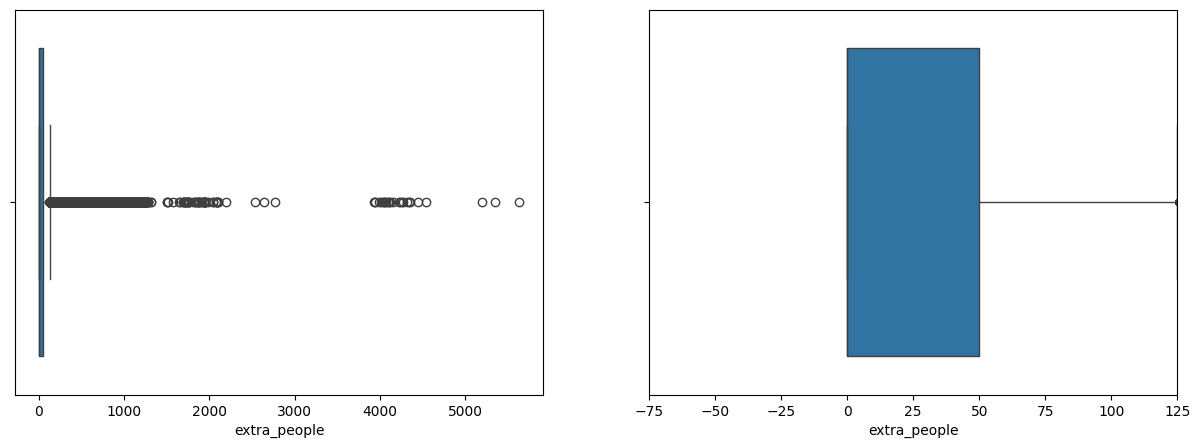

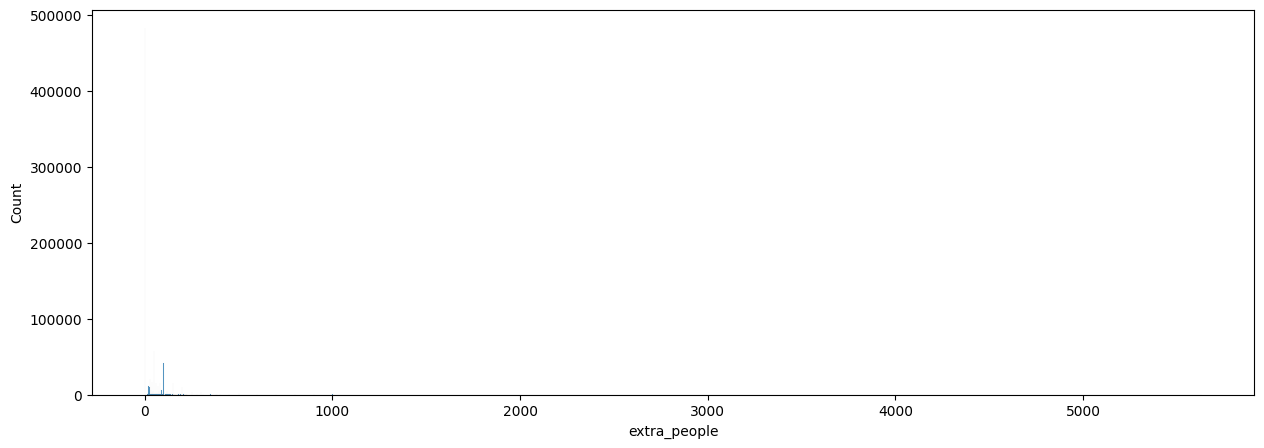

In [78]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [79]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


(751233, 23)


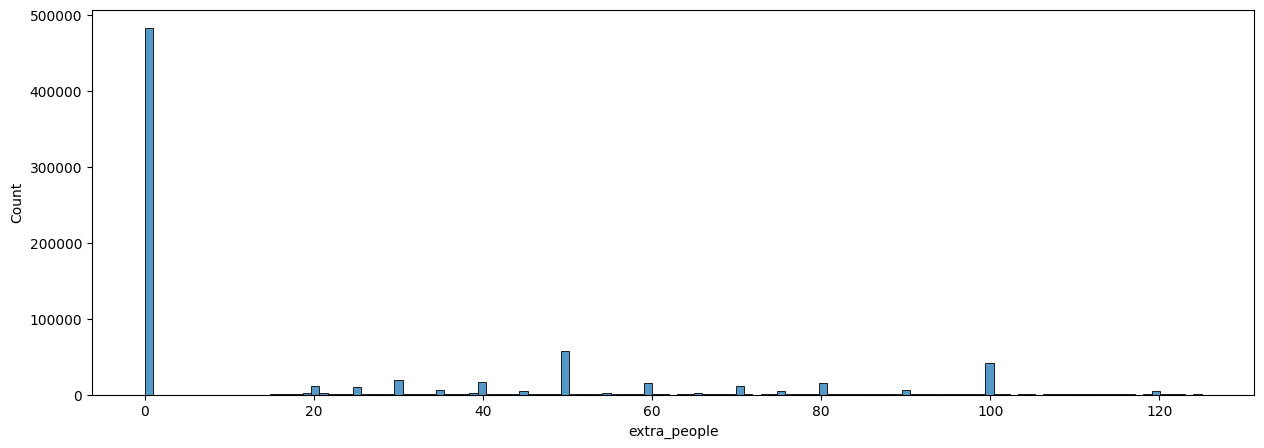

In [80]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_listings_count

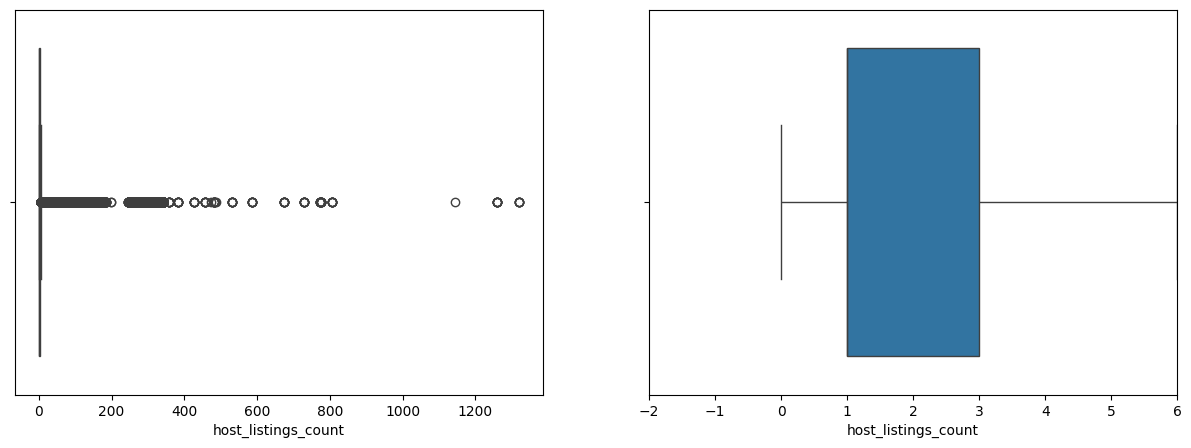

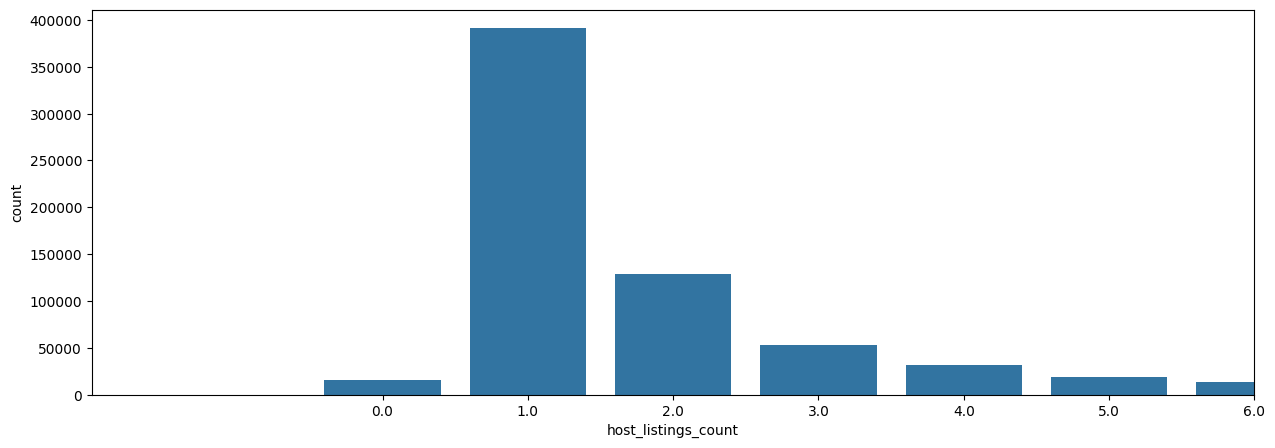

In [81]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Posso excluir os outliers, porque para o objetivo do meu projeto, hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [82]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates

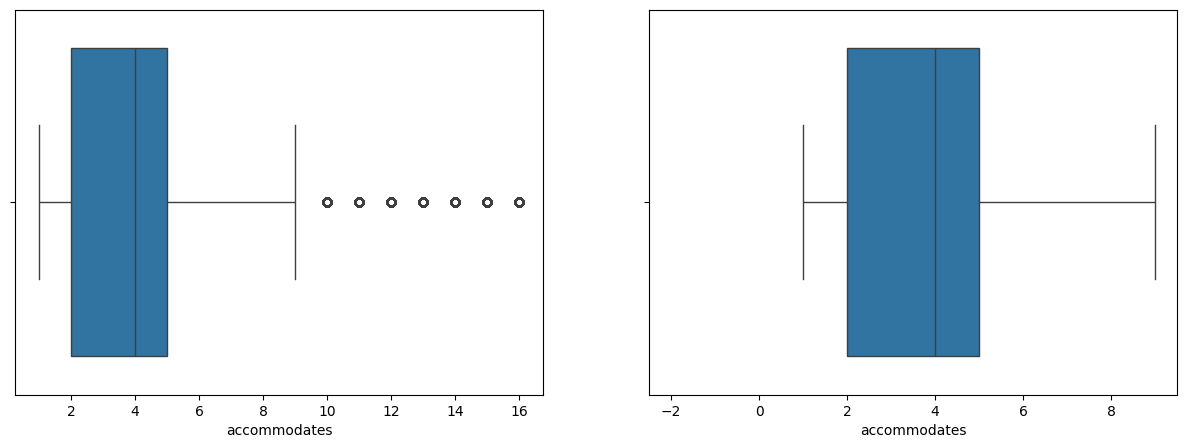

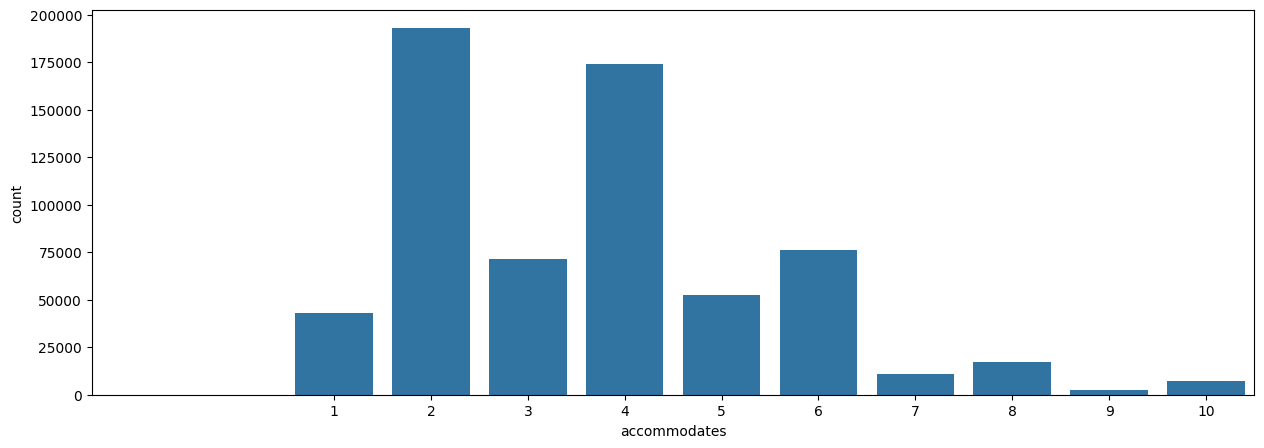

In [83]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vou excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o foco, meu objetivo aqui é para imóveis comuns.

- Caso eu quisesse incluir apartamentos de alto padrão, poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [84]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms 

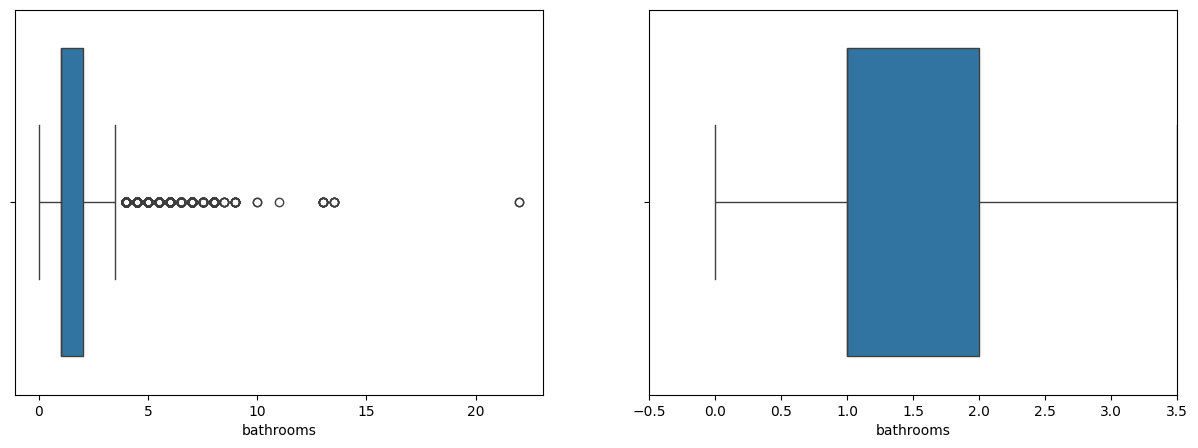

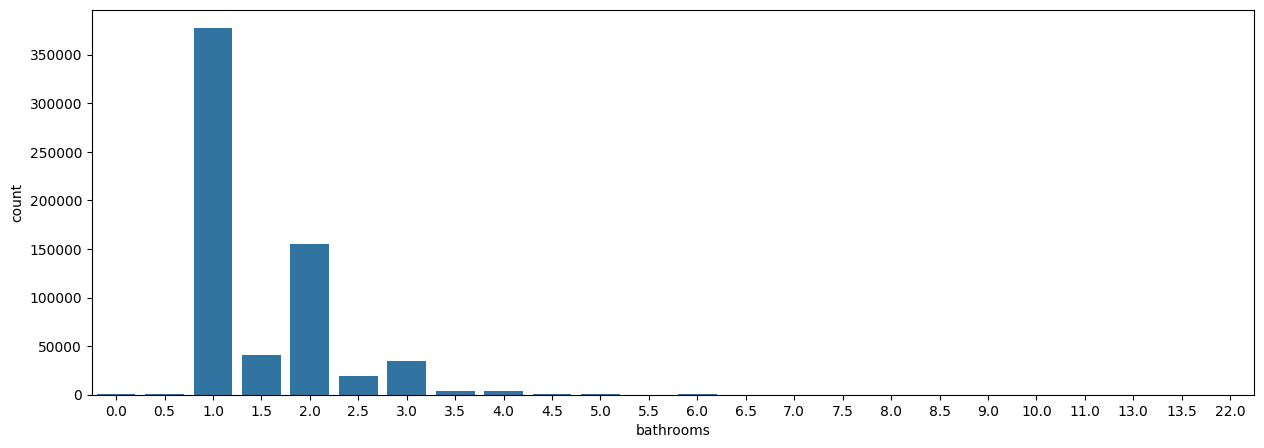

In [85]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts());

- Pelo mesmo motivo dos anteriores, vou excluir os outliers nos banheiros

In [86]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

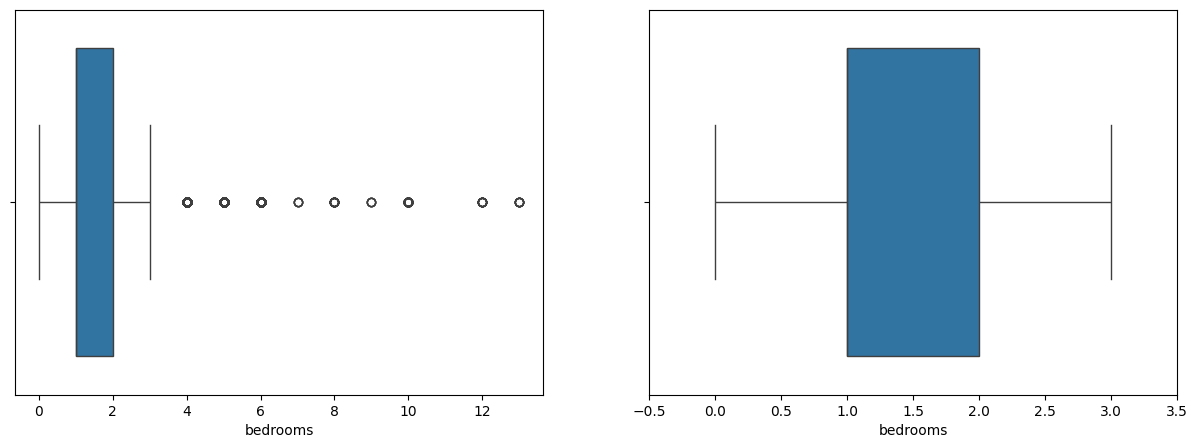

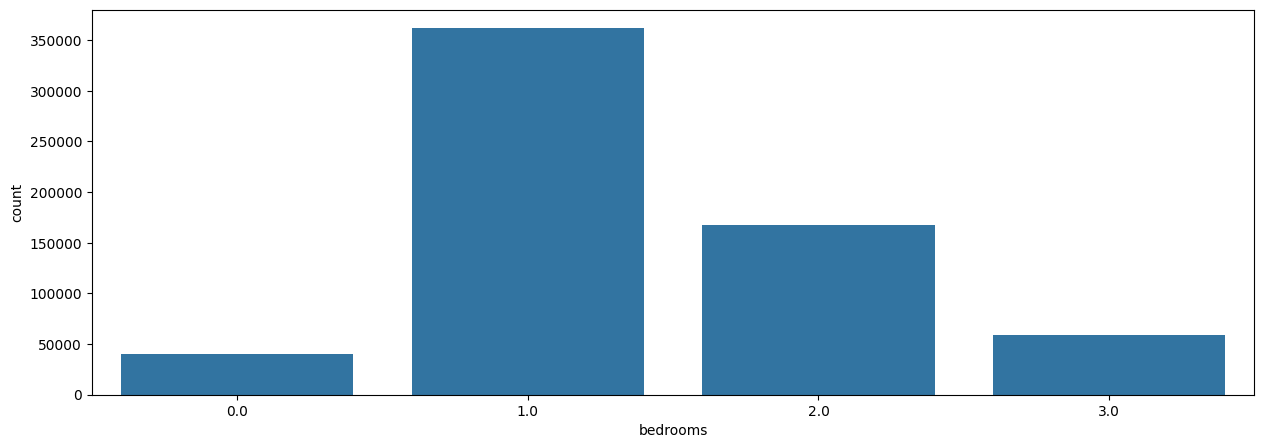

In [87]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Pelo mesmo motivo dos anteriores, vou excluir outliers em quantidade de quartos

In [88]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

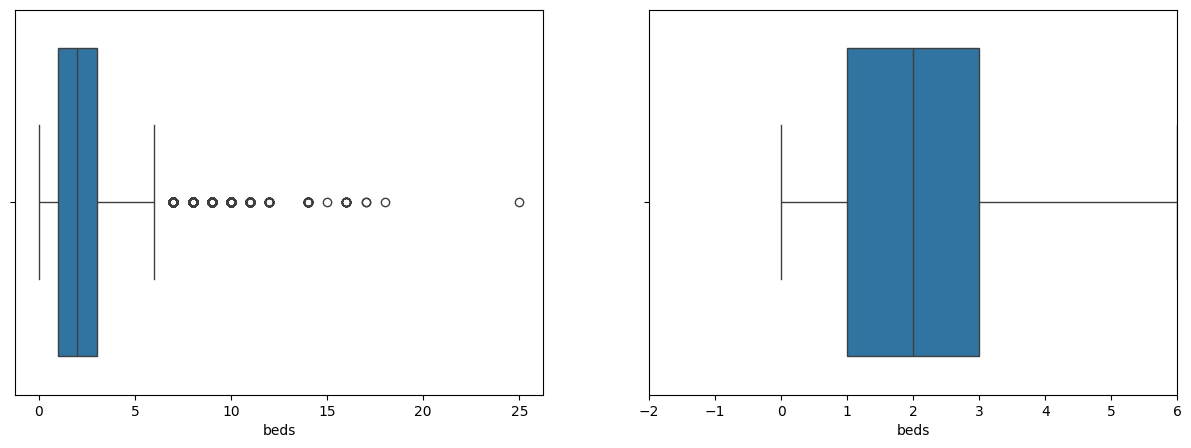

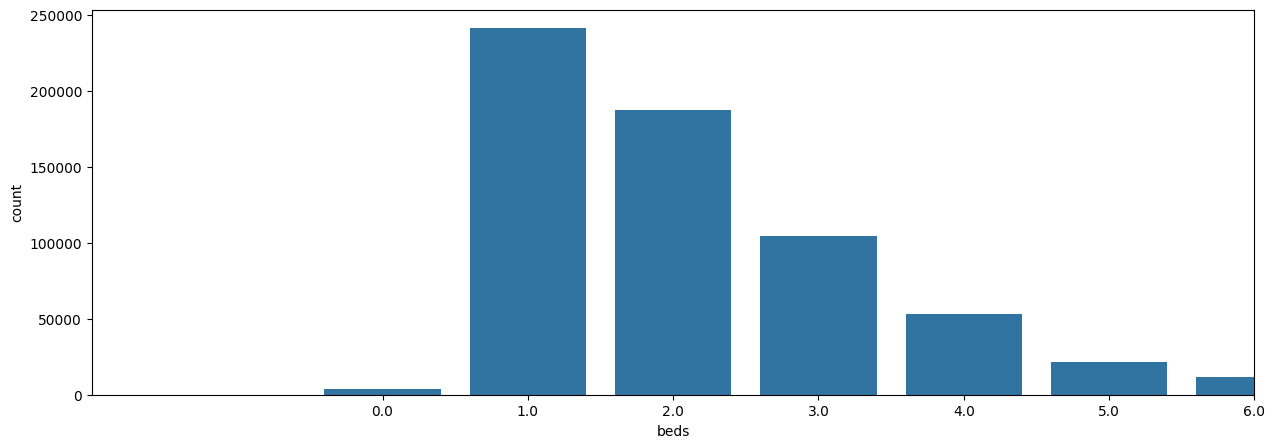

In [89]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- Pelo mesmo motivo dos anteriores, vou excluir outliers em quantidade de camas

In [90]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

(1.0, 1.0)


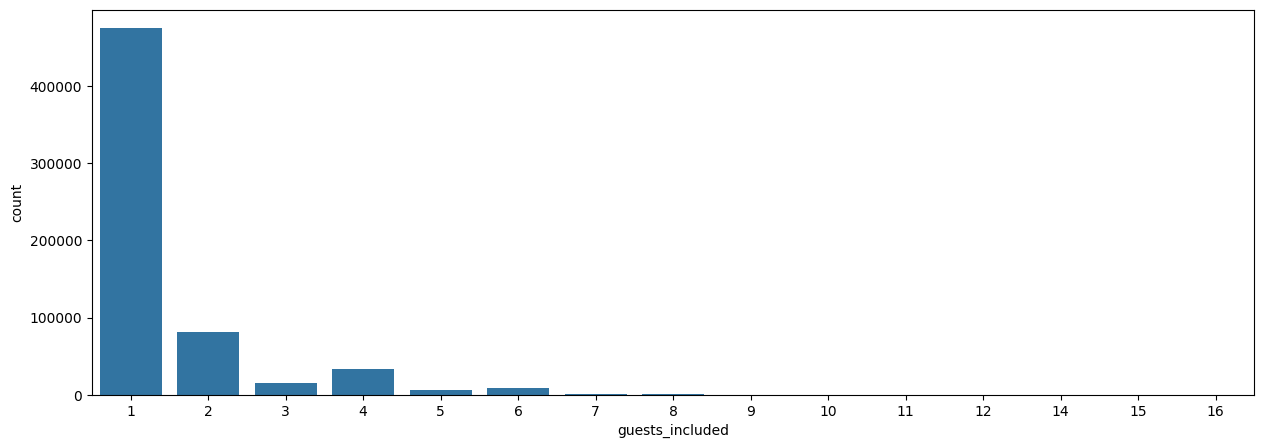

In [91]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts());

Vou remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [92]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

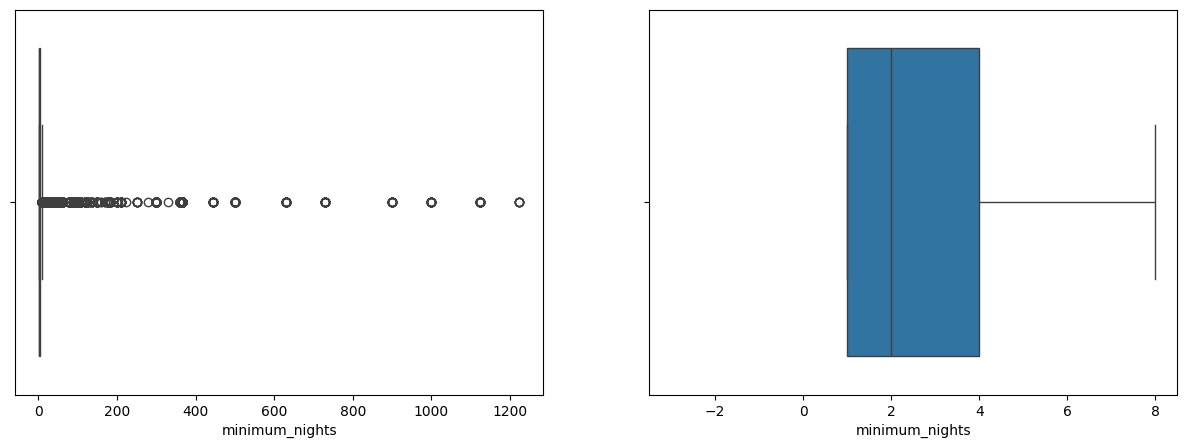

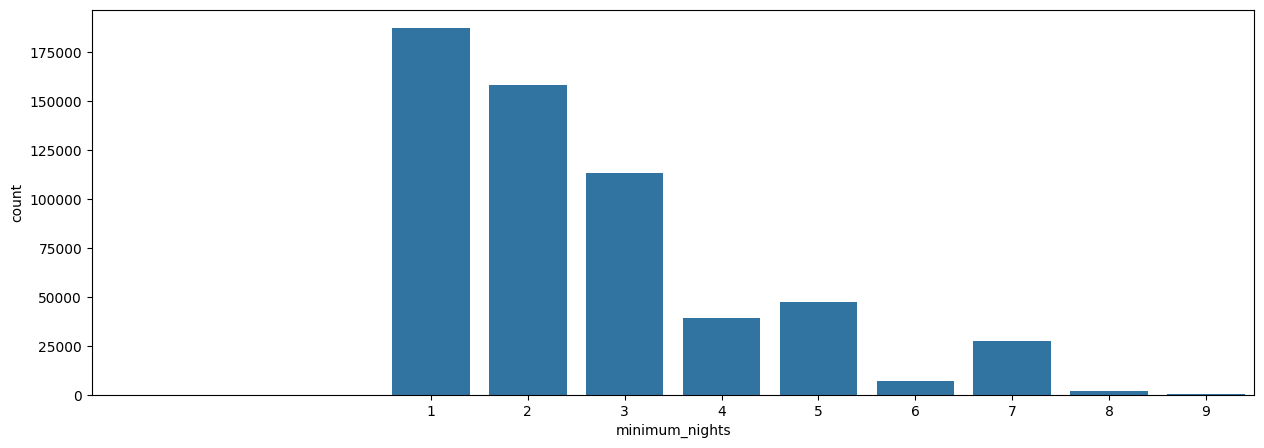

In [93]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- Aqui tenho um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estou querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vou excluir os outliers dessa coluna

In [94]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

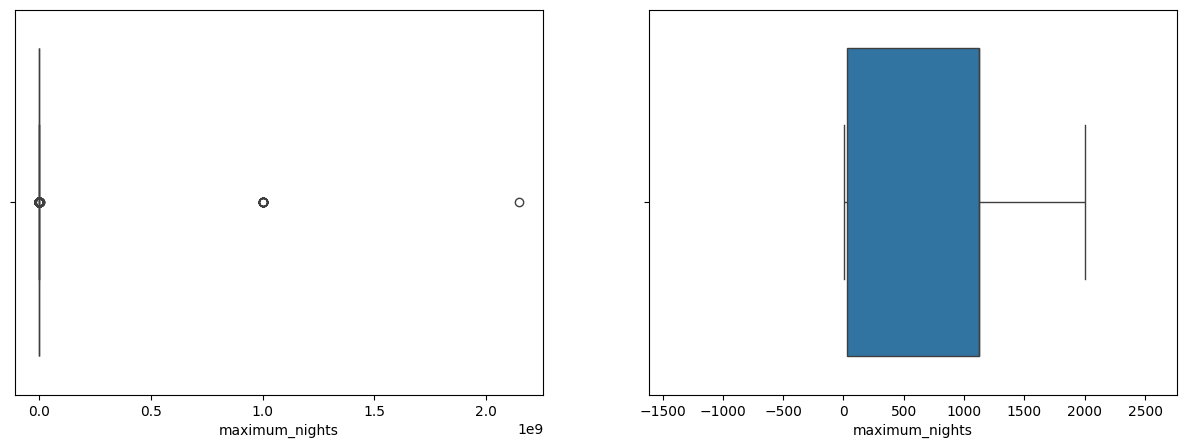

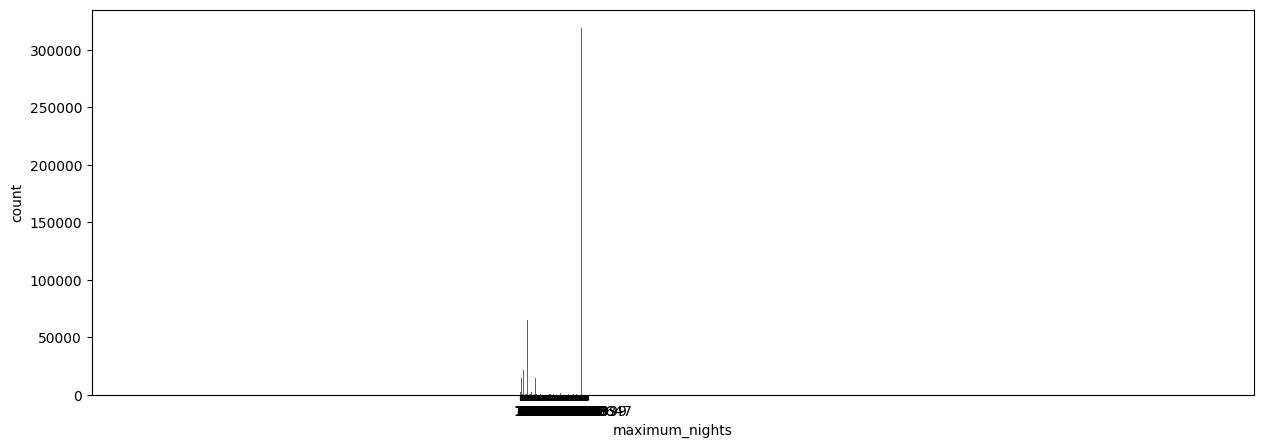

In [95]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluir essa coluna da análise

In [96]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews            

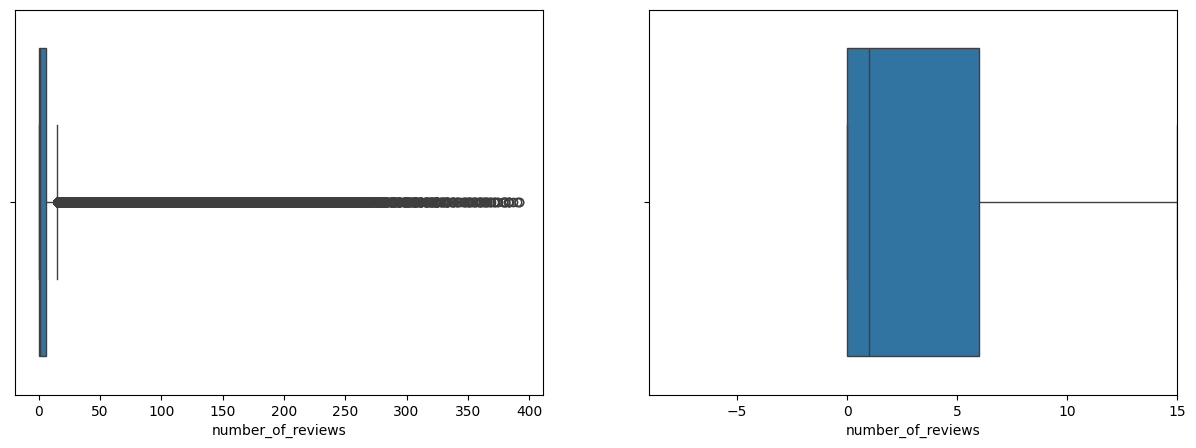

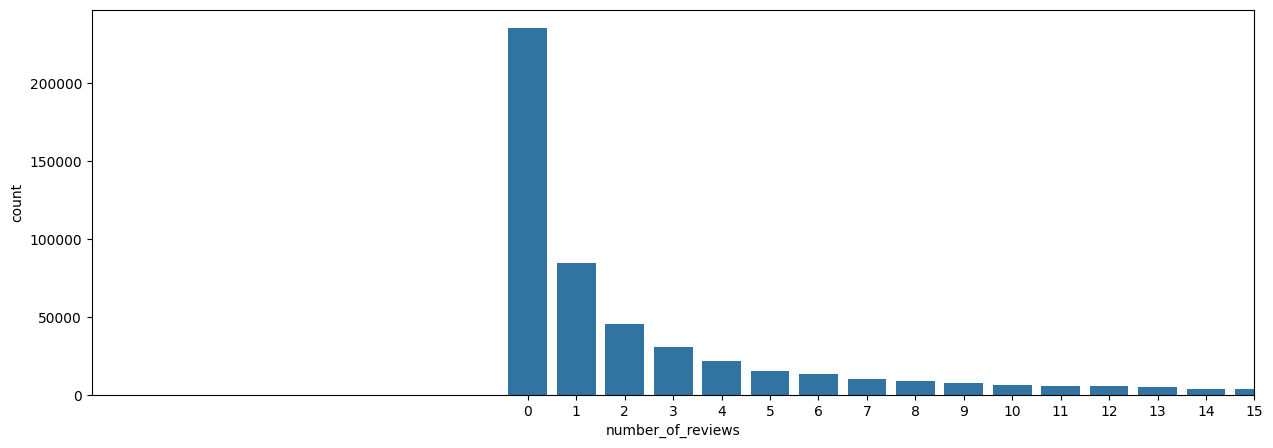

In [97]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se eu excluir os outliers, estarei excluindo as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [98]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto

### - property_type 

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

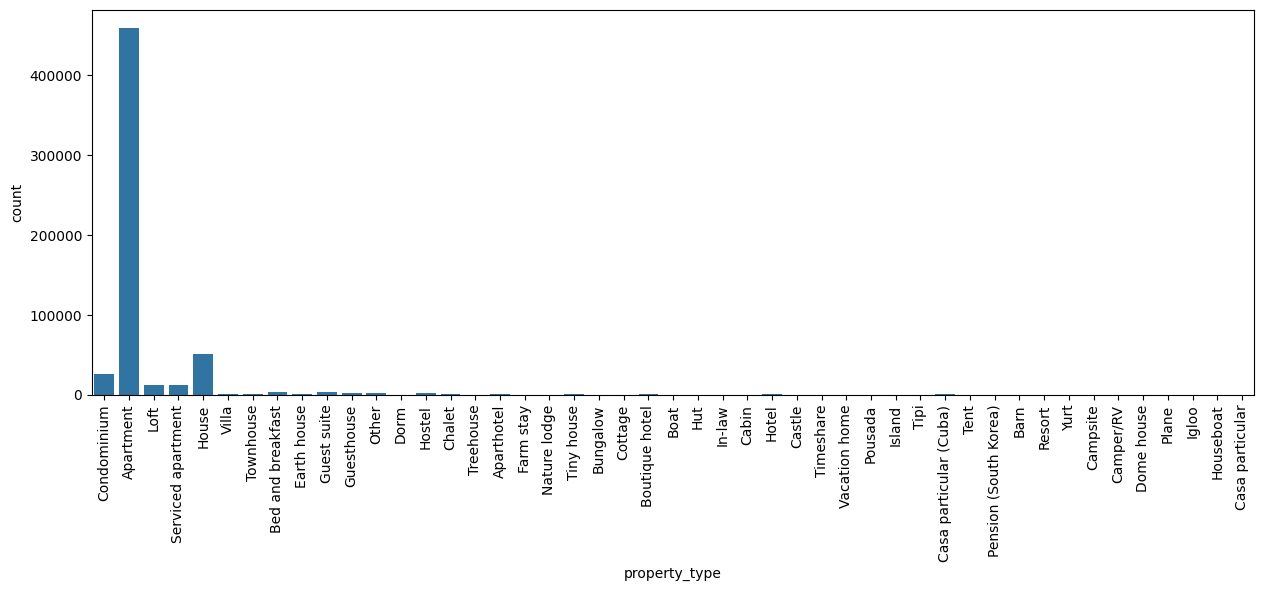

In [99]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Aqui a ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o modelo

property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


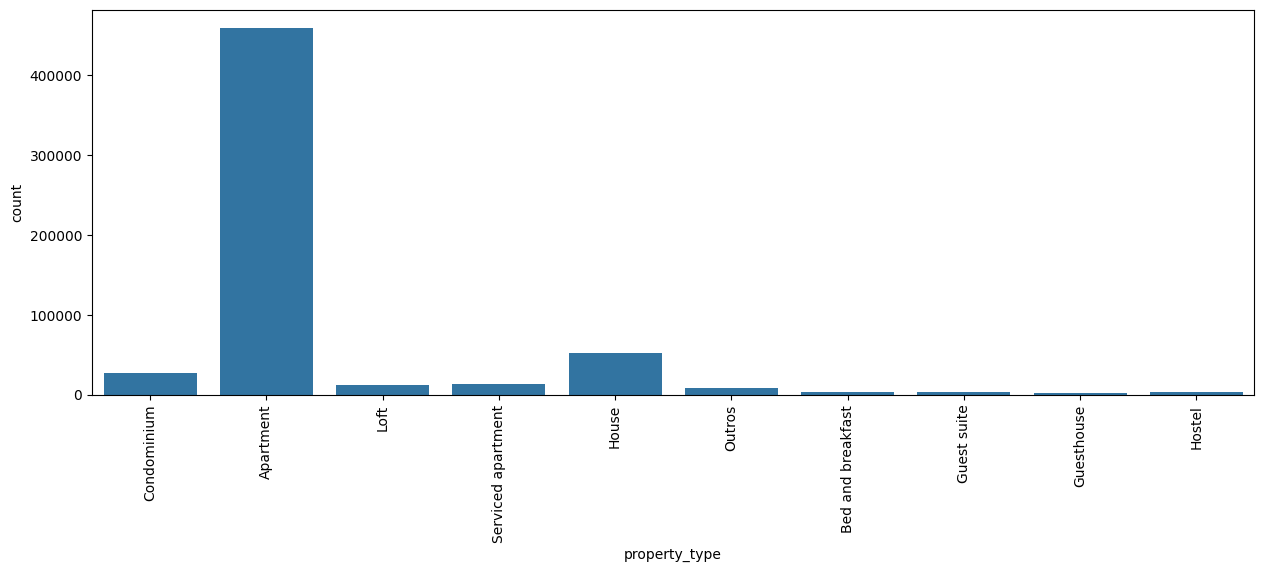

In [100]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### - room_type 

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


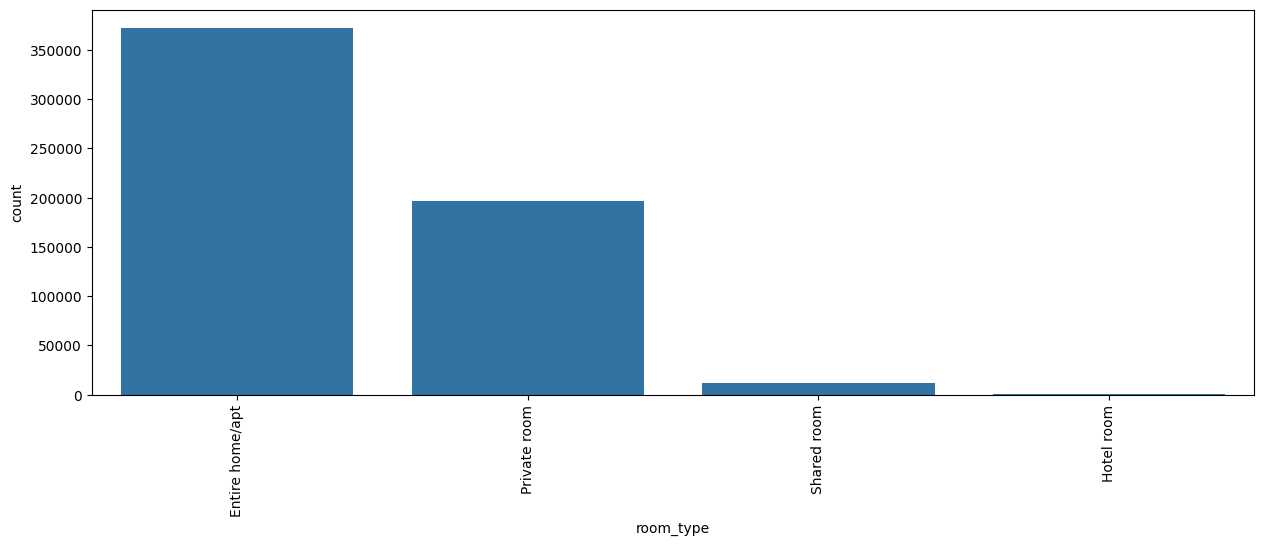

In [101]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Em tipo de quarto, não é necessário fazer nada, ele já parece estar bem distribuído

### - bed_type 

Como fiz com property_type, aqui eu agrupei esta coluna em dois grupos, "Real bed" e "Outros"

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


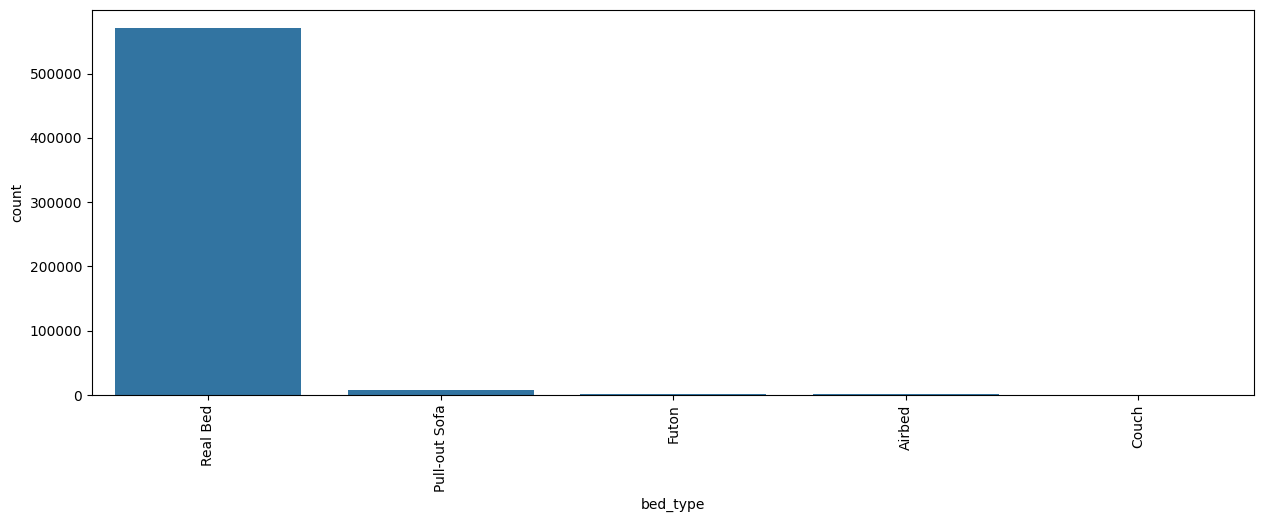

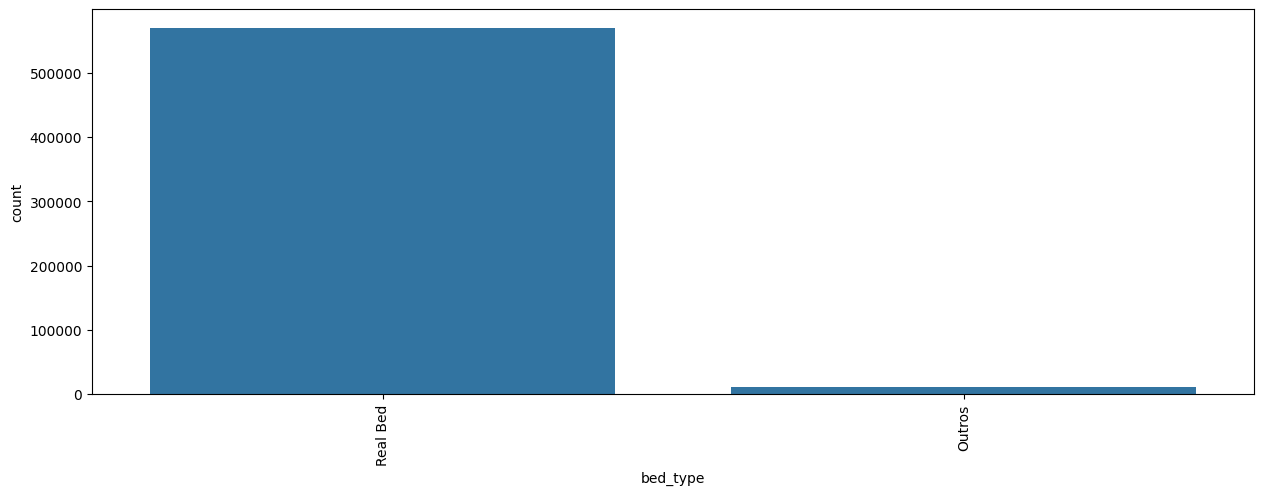

In [102]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### - cancellation_policy 

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64
['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


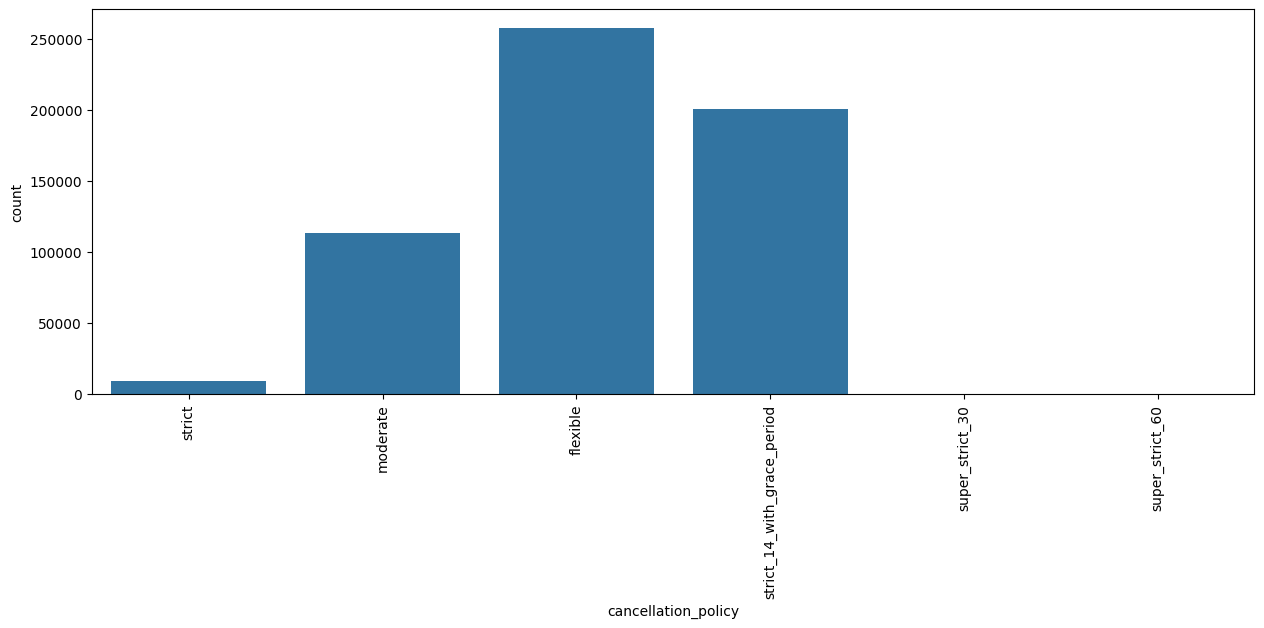

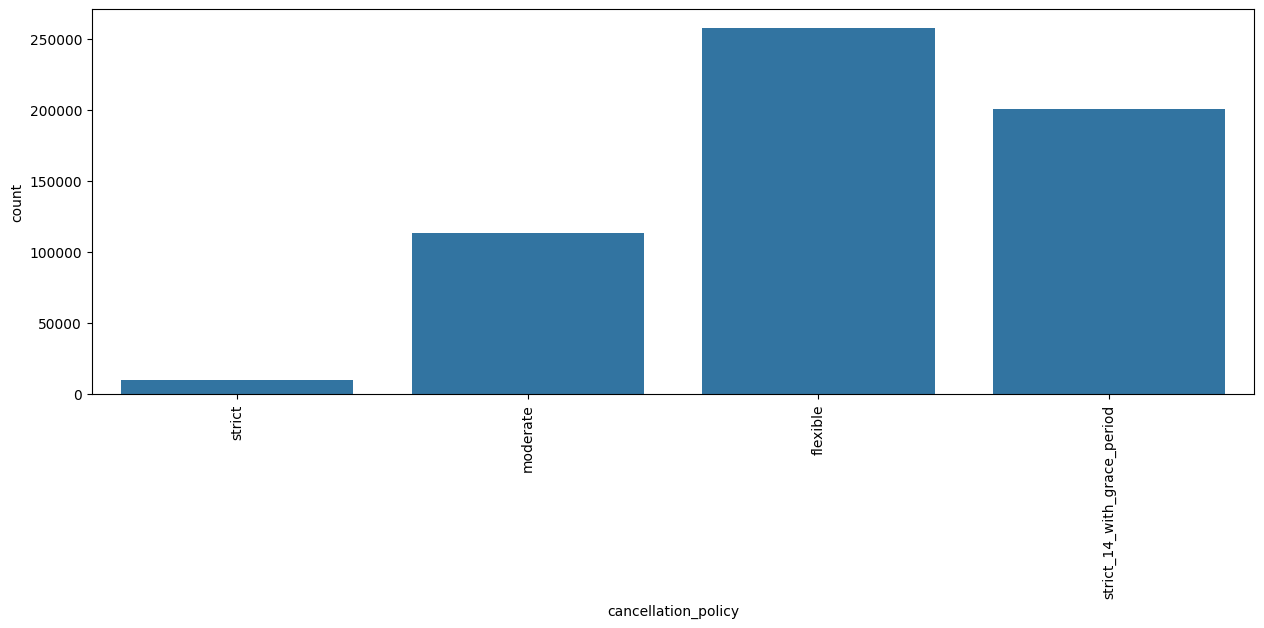

In [103]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de cancellation_pollicy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### - amenities 

Como exite uma diversidade muito grande de amenities e, as vezes, as mesmas amenities podem ser escritas de forma diferente, vou avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [104]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [105]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

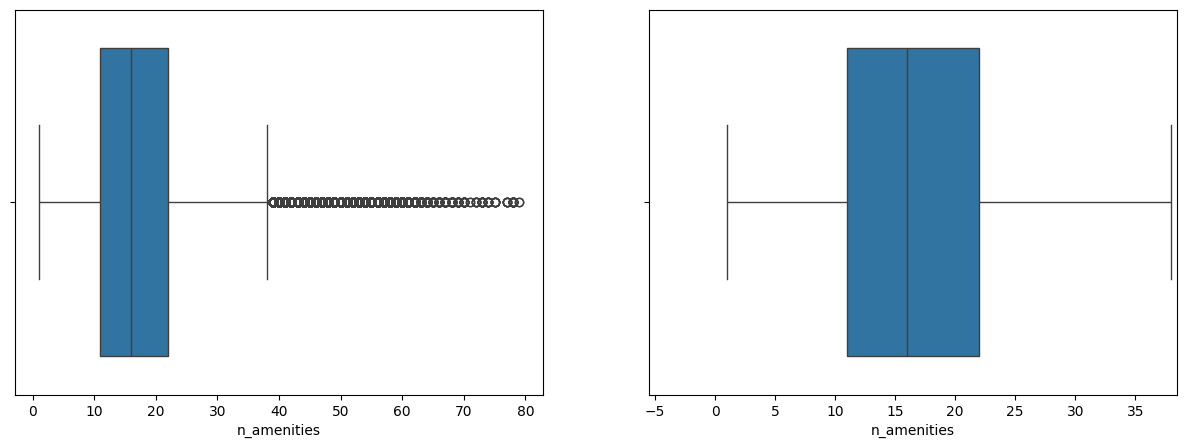

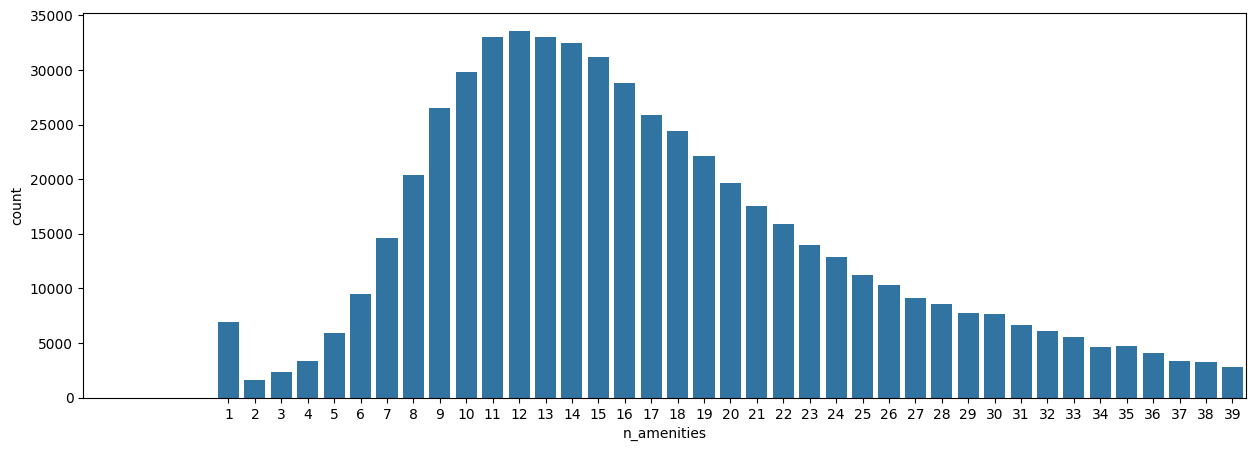

In [106]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu excluí outliers

In [107]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### Visualização de Mapa das Propriedades

Vou criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [108]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

É necessário ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vou substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vou utilizar o método de encoding de variáveis dummies

In [109]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [110]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                       True                False                  False   
3                       True                False                  False   
4                       True                False                  False   
5                       True                False                  False   
6                       True                False                  False   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                  False            False               True   
3                  False            False               True   
4                  False            False               True   
5                  False            False               True   
6                  False            False               True   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                         False                         False   
3                         False                         False   
4                         False                         False   
5                         False                         False   
6                         False                         False   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                        True                                            False  
3                        True                                            False  
4                        True                                            False  
5                        True                                            False  
6                        True                                            False  

[5 rows x 36 columns]

In [111]:
print(base_airbnb_cod.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable',
       'is_business_travel_ready', 'ano', 'mes', 'n_amenities',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Condominium', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Outros', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [112]:
colunas_especificas = [
    'property_type_Apartment', 'property_type_Bed and breakfast',
    'property_type_Condominium', 'property_type_Guest suite',
    'property_type_Guesthouse', 'property_type_Hostel',
    'property_type_House', 'property_type_Loft', 'property_type_Outros',
    'property_type_Serviced apartment', 'room_type_Entire home/apt',
    'room_type_Hotel room', 'room_type_Private room',
    'room_type_Shared room', 'bed_type_Outros', 'bed_type_Real Bed',
    'cancellation_policy_flexible', 'cancellation_policy_moderate',
    'cancellation_policy_strict', 'cancellation_policy_strict_14_with_grace_period'
]

# Converter os valores booleanos dessas colunas para 0 e 1
base_airbnb_cod[colunas_especificas] = base_airbnb_cod[colunas_especificas].astype(int)

display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

Vou usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [113]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que é chamado de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

In [114]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [115]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.36%
RSME:43.01
Modelo LinearRegression:
R²:32.71%
RSME:217.35
Modelo ExtraTrees:
R²:97.54%
RSME:41.53


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não teve uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vou escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²: 97.54%<br>
RSME: 41.53

### Ajustes e Melhorias no Melhor Modelo

[0.01343126 0.03941259 0.10421316 0.10107581 0.07227418 0.06874804
 0.11336763 0.05284906 0.08710915 0.06483526 0.02205861 0.
 0.01124699 0.00471867 0.08942077 0.01247798 0.00140061 0.00527384
 0.00066477 0.00098785 0.00063366 0.00717014 0.00224699 0.00224394
 0.00227751 0.06727349 0.00027079 0.00438348 0.00183557 0.00263271
 0.00276903 0.01962198 0.01248543 0.00088261 0.00770644]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'ano',
       'mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel r

0
bedrooms                                         0.113368
latitude                                         0.104213
longitude                                        0.101076
n_amenities                                      0.089421
extra_people                                     0.087109
accommodates                                     0.072274
bathrooms                                        0.068748
room_type_Entire home/apt                        0.067273
minimum_nights                                   0.064835
beds                                             0.052849
host_listings_count                              0.039413
instant_bookable                                 0.022059
cancellation_policy_flexible                     0.019622
host_is_superhost                                0.013431
cancellation_policy_moderate                     0.012485
property_type_Apartment                          0.012478
ano                                              0.011247
cancellation_policy_strict_14_with_grace_period  0.007706
property_type_House                              0.007170
property_type_Condominium                        0.005274
mes                                              0.004719
room_type_Private room                           0.004383
bed_type_Real Bed                                0.002769
bed_type_Outros                                  0.002633
property_type_Serviced apartment                 0.002278
property_type_Loft                               0.002247
property_type_Outros                             0.002244
room_type_Shared room                            0.001836
property_type_Bed and breakfast                  0.001401
property_type_Guesthouse                         0.000988
cancellation_policy_strict                       0.000883
property_type_Guest suite                        0.000665
property_type_Hostel                             0.000634
room_type_Hotel room                             0.000271
is_business_travel_ready                         0.000000

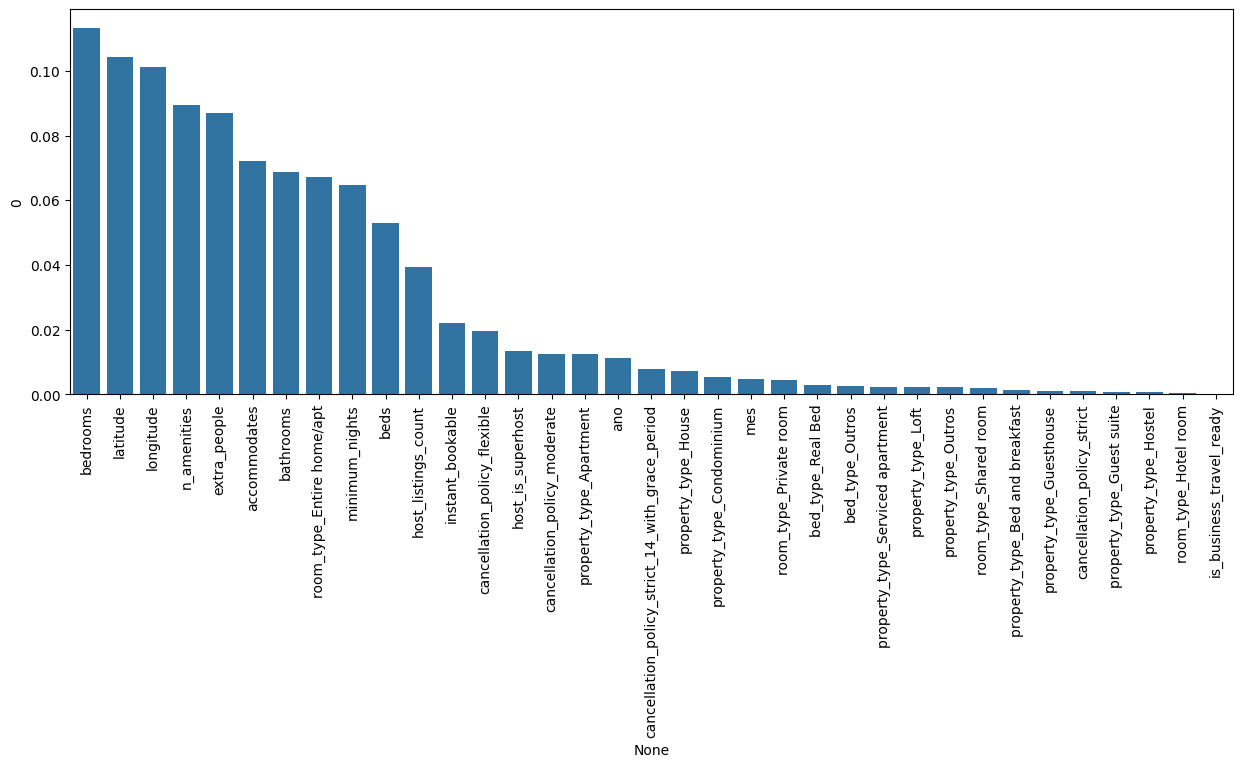

In [116]:
print(modelo_et.feature_importances_)
print(X_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no modelo. Por isso, para chegar em um modelo mais simples, vou excluir essa feature e testar o modelo sem ela.

In [117]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.52%
RSME:41.75


In [118]:
print(previsao)

[ 451.    131.08 1162.24 ...   61.21  162.09  598.84]
